Uniaxial materials describe the relationship between strain (or deformation) and stress (or force) in one dimension. They are often used to simulate the behavior of truss elements where forces and deformations act along a single axis. These materials also model fibers in fiber sections by capturing the axial stress-strain relationship of each fiber. In addition, uniaxial materials can represent moment-rotation behavior for concentrated plasticity hinges at discrete sections in structural elements, providing a straightforward yet powerful way to capture nonlinear effects.

Despite their versatility, uniaxial materials have limitations in accurately representing multi-axial or coupled responses. They do not inherently model effects like buckling or shear interaction and may require supplemental formulations or more advanced modeling approaches to capture these complexities.

We can interact with a uniaxial material using the `getStress` method. This method takes the following arguments:

> ```python
> getStress(strain: float = None, commit: bool =False) -> float
> ```


In [1]:
import matplotlib.pyplot as plt
try:
    # Try loading a plotting style that may not be installed
    plt.style.use("typewriter")
except:
    pass

## Plasticity

Before beginning, we'll import some constants from the `opensees.units` submodules that will help us keep track of units.

In [2]:
from opensees.units.english import ksi, psi

Now we'll define some properties that are representative of structural steel. `Fy` is the yield stress, and `Es` the initial Young's modulus.

In [3]:
Fy  = 66.8*ksi             # steel yield stress
Es  = 29000.*ksi           # modulus of steel


Next we'll create and plot a simple strain history. Here we use [`numpy`](https://numpy.org) for basic array processing and [`matplotlib`] for plotting.

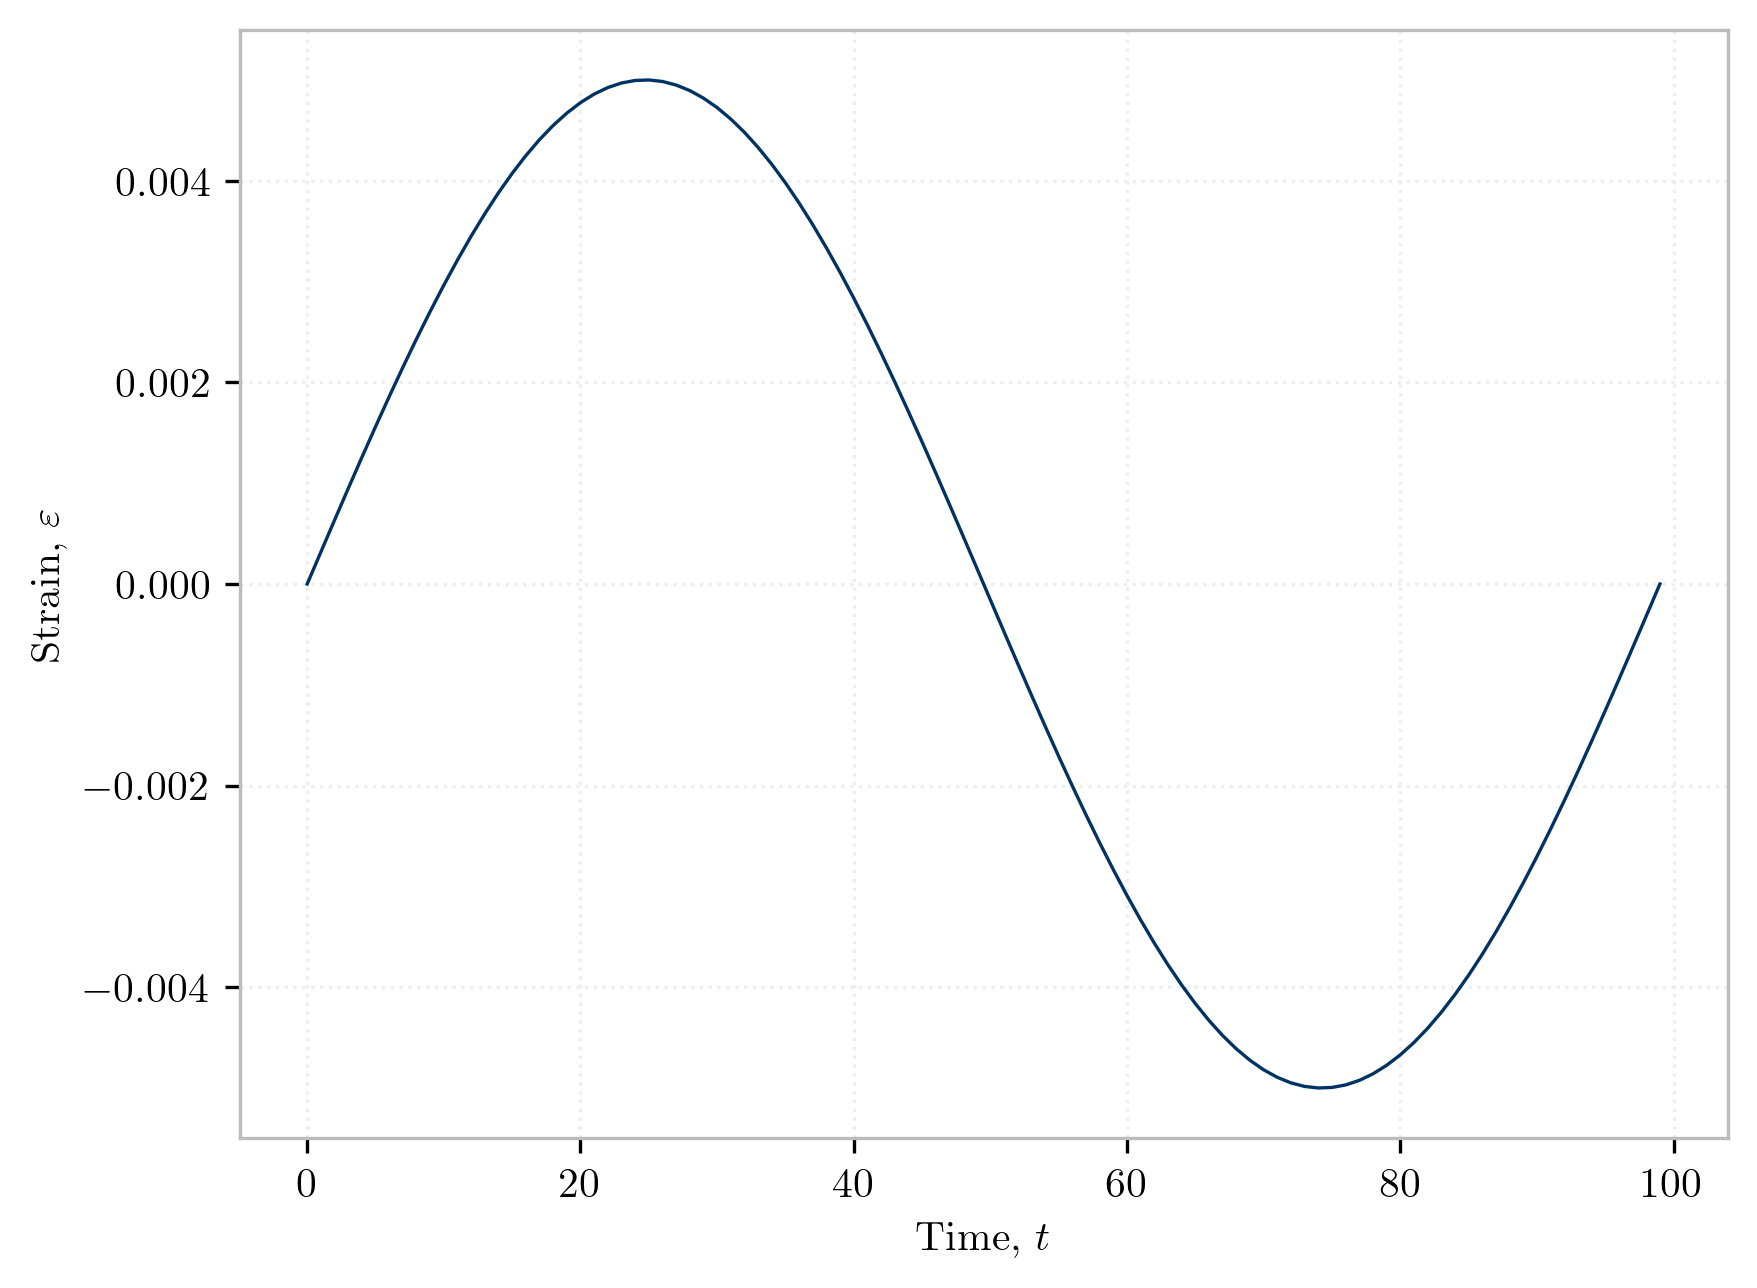

In [4]:
from numpy import sin, linspace, pi, sqrt
strain = 0.005*sin(linspace(0, 2.0*pi, 100))

fix, ax = plt.subplots()
ax.plot(strain)
ax.set_ylabel(r"Strain, $\varepsilon$")
ax.set_xlabel(r"Time, $t$");


Now we are ready to bring in the `opensees` library. We initialize an empty list `stress`, then create the material, and loop over the strains we just created to collect the stresses.

In [5]:
from opensees import uniaxial

stress = []
elastic_pp_material = uniaxial.ElasticPP(Es, Fy/Es)

with elastic_pp_material.handle() as mat:

    for e in strain:
        stress.append(mat.getStress(e, commit=True)/Fy)


Now we'll plot the stress response we've just collected as a function of strain. For this we'll first create a figure with axes using the [`subplots`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) function from `matplotlib`, then we'll use the `.plot()` method of the axes to add our data.

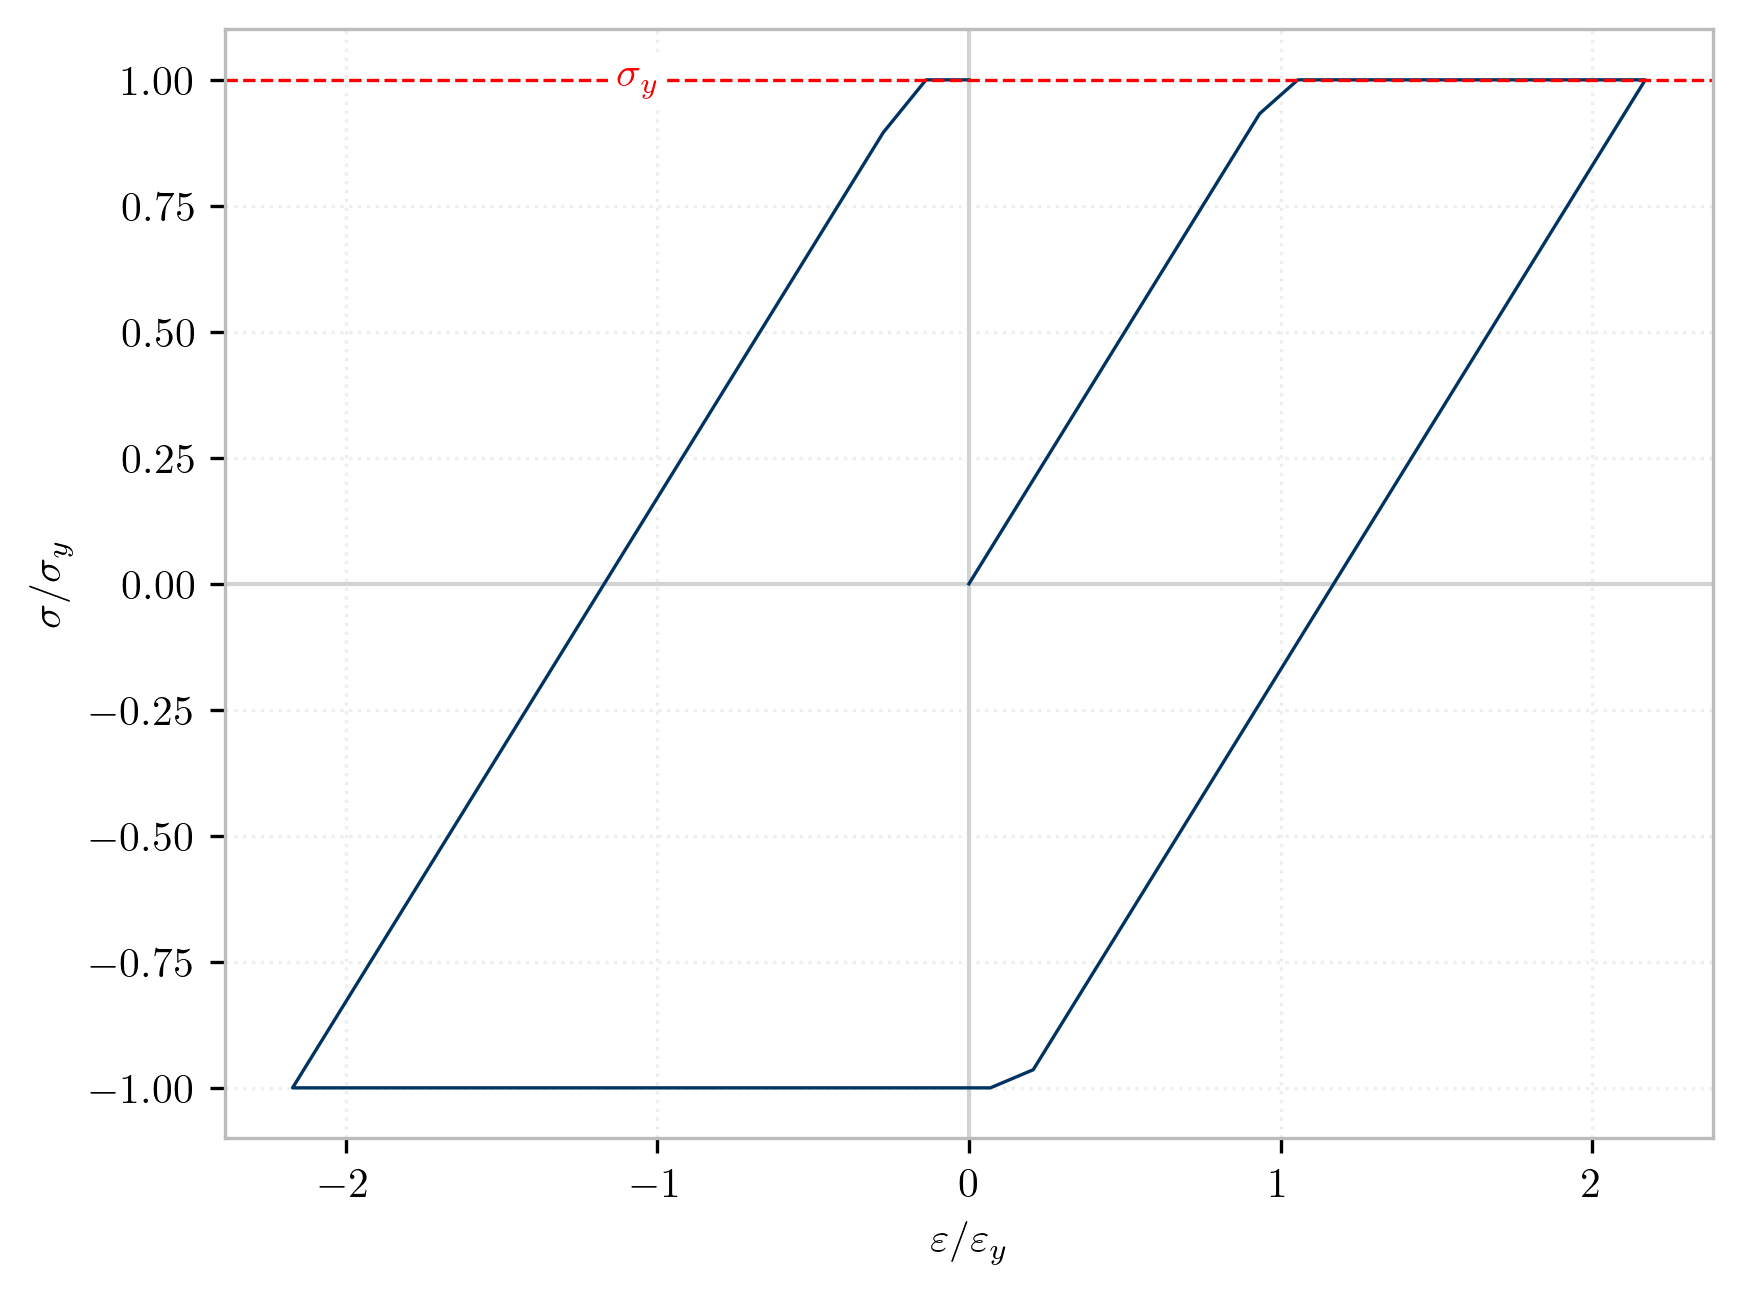

In [6]:
# create a plotting figure
fig, ax = plt.subplots()    
ax.axhline(0, color='lightgrey', linestyle='-', linewidth=1)
ax.axvline(0, color='lightgrey', linestyle='-', linewidth=1)
ax.plot(strain/(Fy/Es), stress)

# Draw a horizontal line at the yield stress Fy
ax.axhline(y=1, color='r', linestyle='--')
ax.text(-1, 1, r"$\sigma_y$", color='r', va='center', ha='right', bbox=dict(facecolor='white', edgecolor='none', pad=2.0))
ax.set_xlabel(r"$\varepsilon/\varepsilon_y$")
ax.set_ylabel(r"$\sigma/\sigma_y$");

## Reinforcing Steel
While a perfectly plastic model is simple and convenient, it fails to capture several important aspects of real steel behavior. To address this, reinforcing steel models often account for:

- Hardening
- Bauschinger effect
- Low-cycle fatigue
- Buckling

The most commonly used reinforcing steel model is [`Steel02`](https://opensees.stairlab.io/user/manual/material/uniaxialMaterials/Steel02.html).

In [7]:
Bs  = 0.005                # strain-hardening ratio 
R0  = 18                   # control the transition from elastic to plastic branches
cR1 = 0.925                # "
cR2 = 0.15                 # "

Dodd_Restrepo unaxial material - Written by L.L. Dodd & J. Restepo


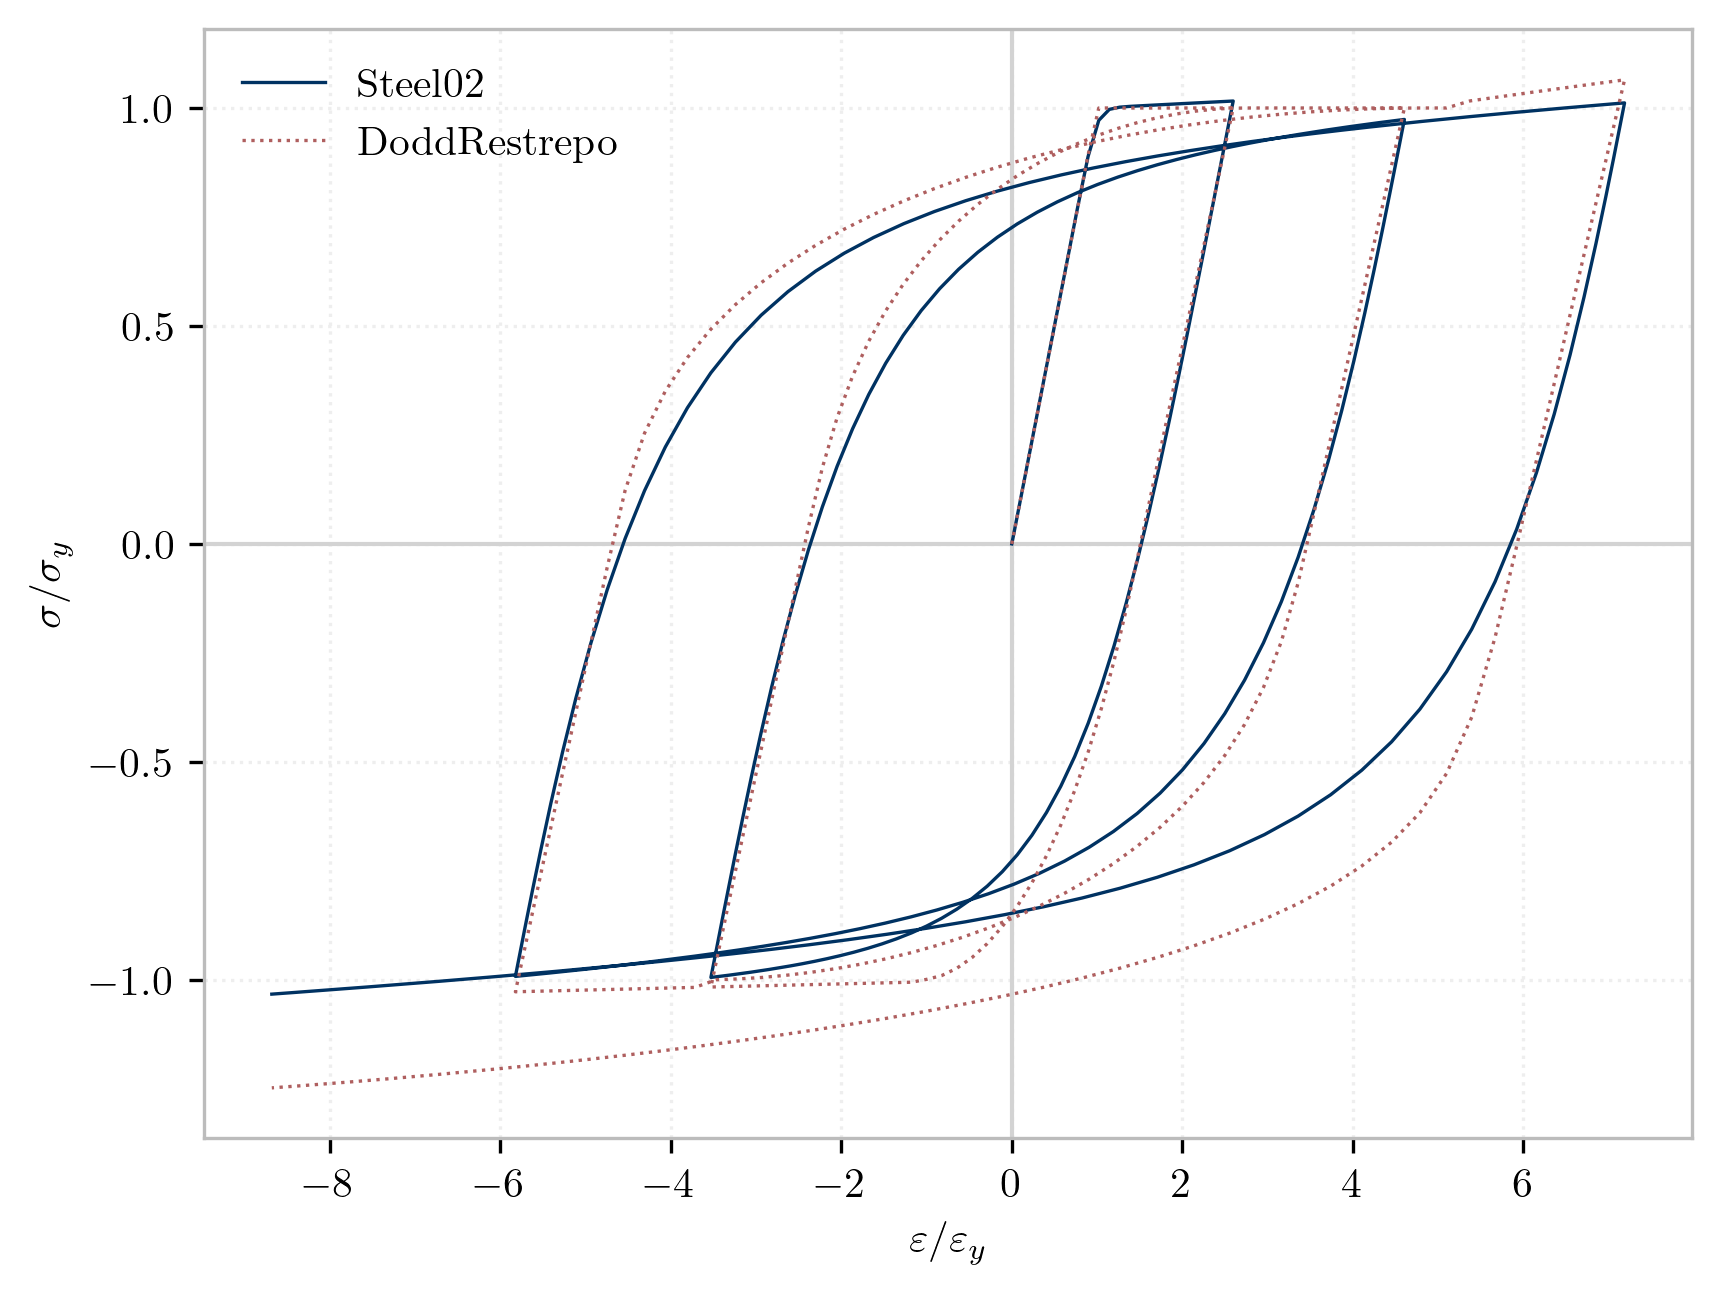

In [8]:
strain = 0.02*sin(linspace(0, 5.5*pi, 300))*linspace(0.5, 1, 300)**2

Bs = 0.01
fig, ax = plt.subplots()
ax.axhline(0, color='lightgrey', linestyle='-', linewidth=1)
ax.axvline(0, color='lightgrey', linestyle='-', linewidth=1)

with uniaxial.Steel02(Fy, Es, Bs, R0).handle() as steel:
    ax.plot(strain/(Fy/Es), [steel.getStress(e, commit=True)/Fy for e in strain], label="Steel02")


# with uniaxial.RambergOsgoodSteel(Fy, Es, 0.002, R0).handle() as steel:
#     ax.plot(strain, [steel.getStress(e, commit=True) for e in strain], label="RambergOsgoodSteel")


esh, esu = 10*Fy/Es, 20*Fy/Es
eshi = (esu + 5*esh)/5
with uniaxial.DoddRestrepo(Fy, 1.2*Fy, esh, esu, Es, eshi, 1.1*Fy).handle() as steel:
    ax.plot(strain/(Fy/Es), [steel.getStress(e, commit=True)/Fy for e in strain], ":", label="DoddRestrepo")


# n = 11
# c = (Es/Fy)**(n)
# eta = [0.0*c, 1.*c]
# with uniaxial.BoucWen(Bs, 1., n, eta, [1, 0.0], [0.0, 0.0]) as m:
#     stress = [Es*m.getStress(e, commit=True) for e in strain]
#     ax.plot(strain, stress, "-.", label="BoucWen - GMP")

# eta = [0.5*c, 0.5*c]
# with uniaxial.BoucWen(Bs, 1., n, eta, [1, 0.0], [0.0, 0.0]) as m:
#     stress = [Es*m.getStress(e, commit=True) for e in strain]
#     ax.plot(strain, stress, "-.", label="BoucWen - Plastic")
    
# uniaxial.Bond_SP01(Fy, Sy=1.0, Fu=1.4*Fy, Su=, b=, R=)

ax.set_xlabel(r"$\varepsilon/\varepsilon_y$")
ax.set_ylabel(r"$\sigma/\sigma_y$")
fig.savefig("img/steel.png")
ax.legend();

## Concrete

In [9]:
# nominal concrete compressive strength
fc = -8.5*ksi              # Concrete compressive strength ksi   (+Tension -Compression)
Ec = 57*ksi*sqrt(-fc/psi)  # Concrete Elastic Modulus

# unconfined concrete
fc1U = fc                  # unconfined concrete maximum stress (Todeschini parabola) 
eps1U = -0.003             # strain at maximum strength of unconfined concrete
fc2U = 0.2*fc1U            # ultimate stress
eps2U = -0.01              # strain at ultimate stress
_lambda = 0.1              # ratio between unloading slope at eps2 and initial slope Ec

# tensile-strength properties
ftU = -0.14*fc1U           # tensile strength +tension
Ets = ftU/0.002            # tension softening stiffness

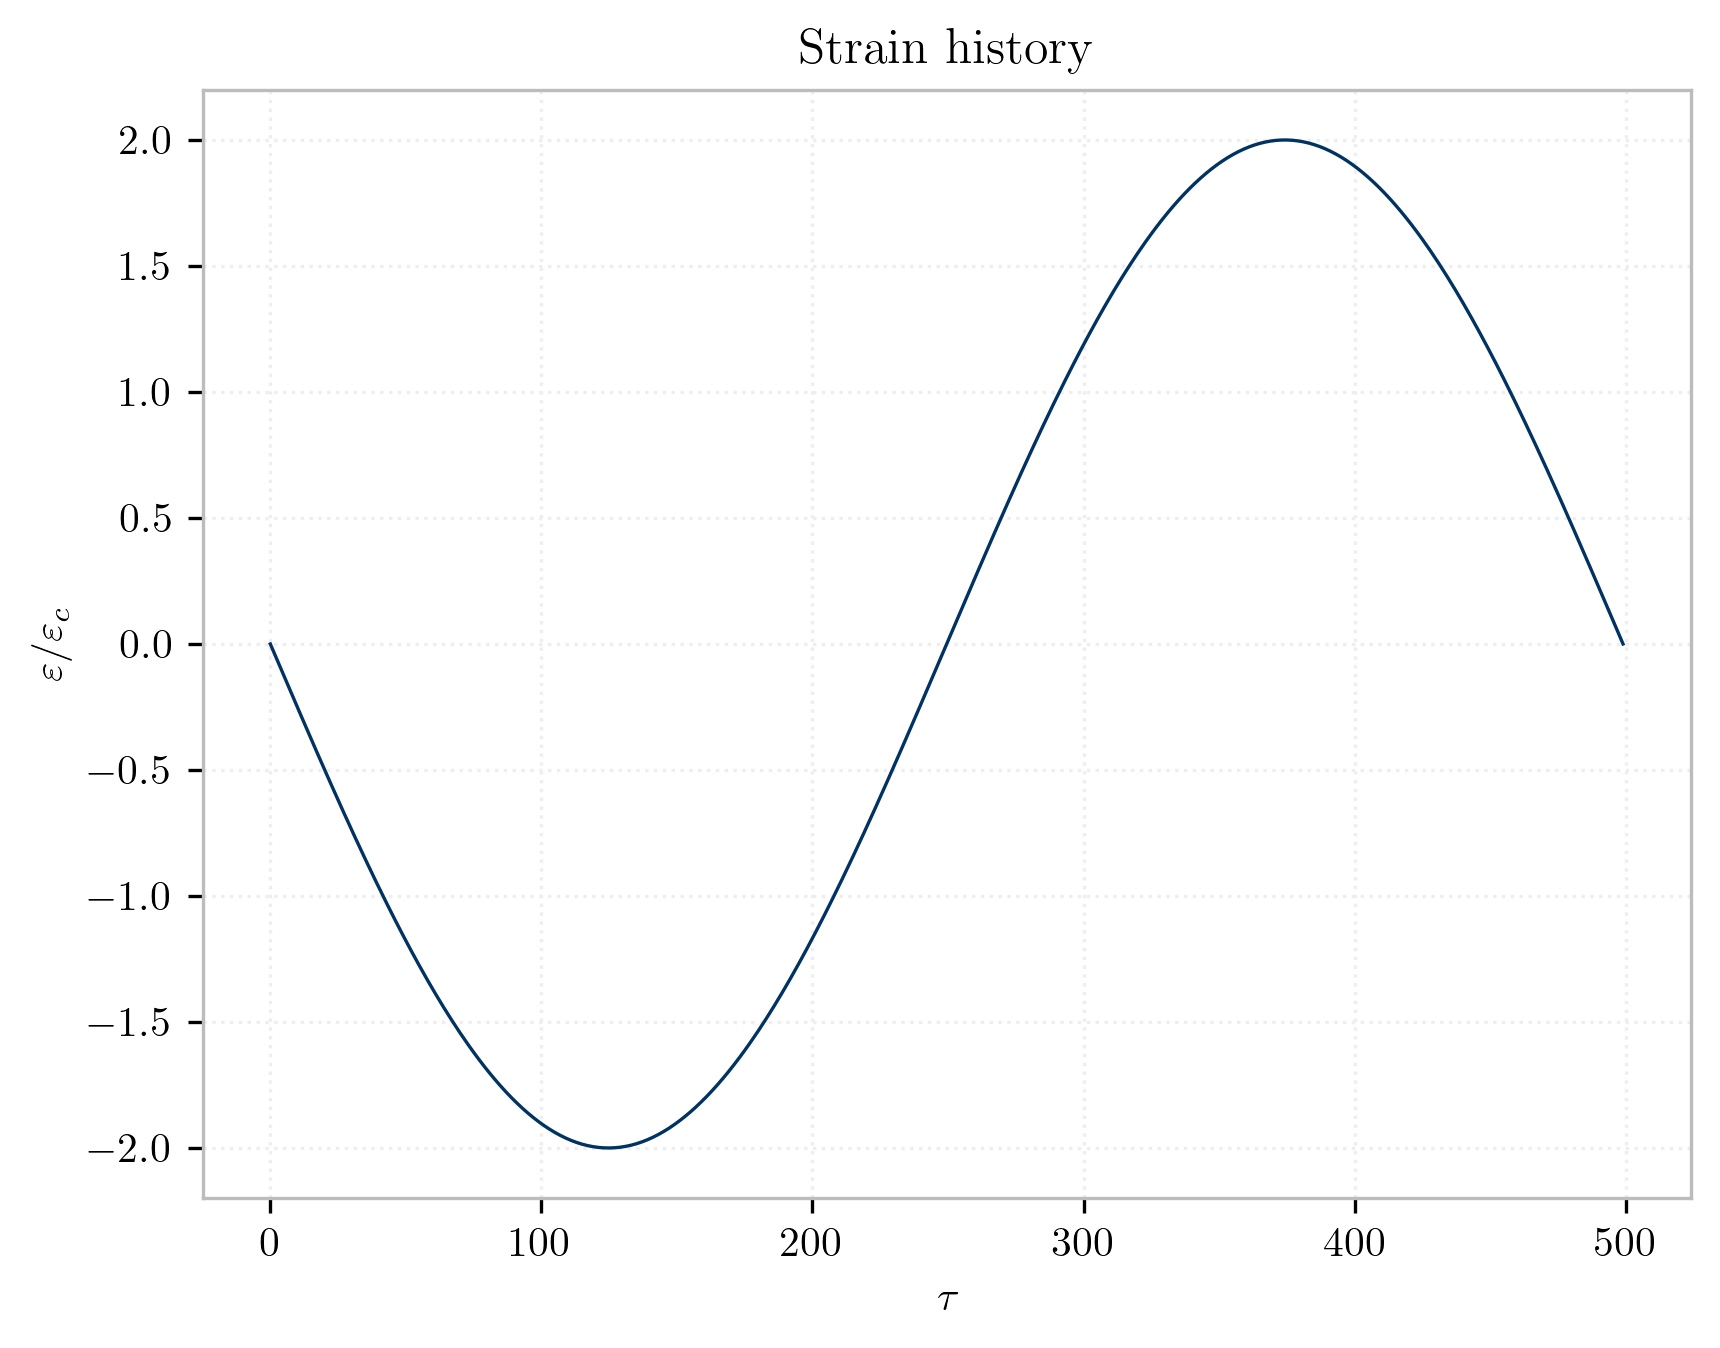

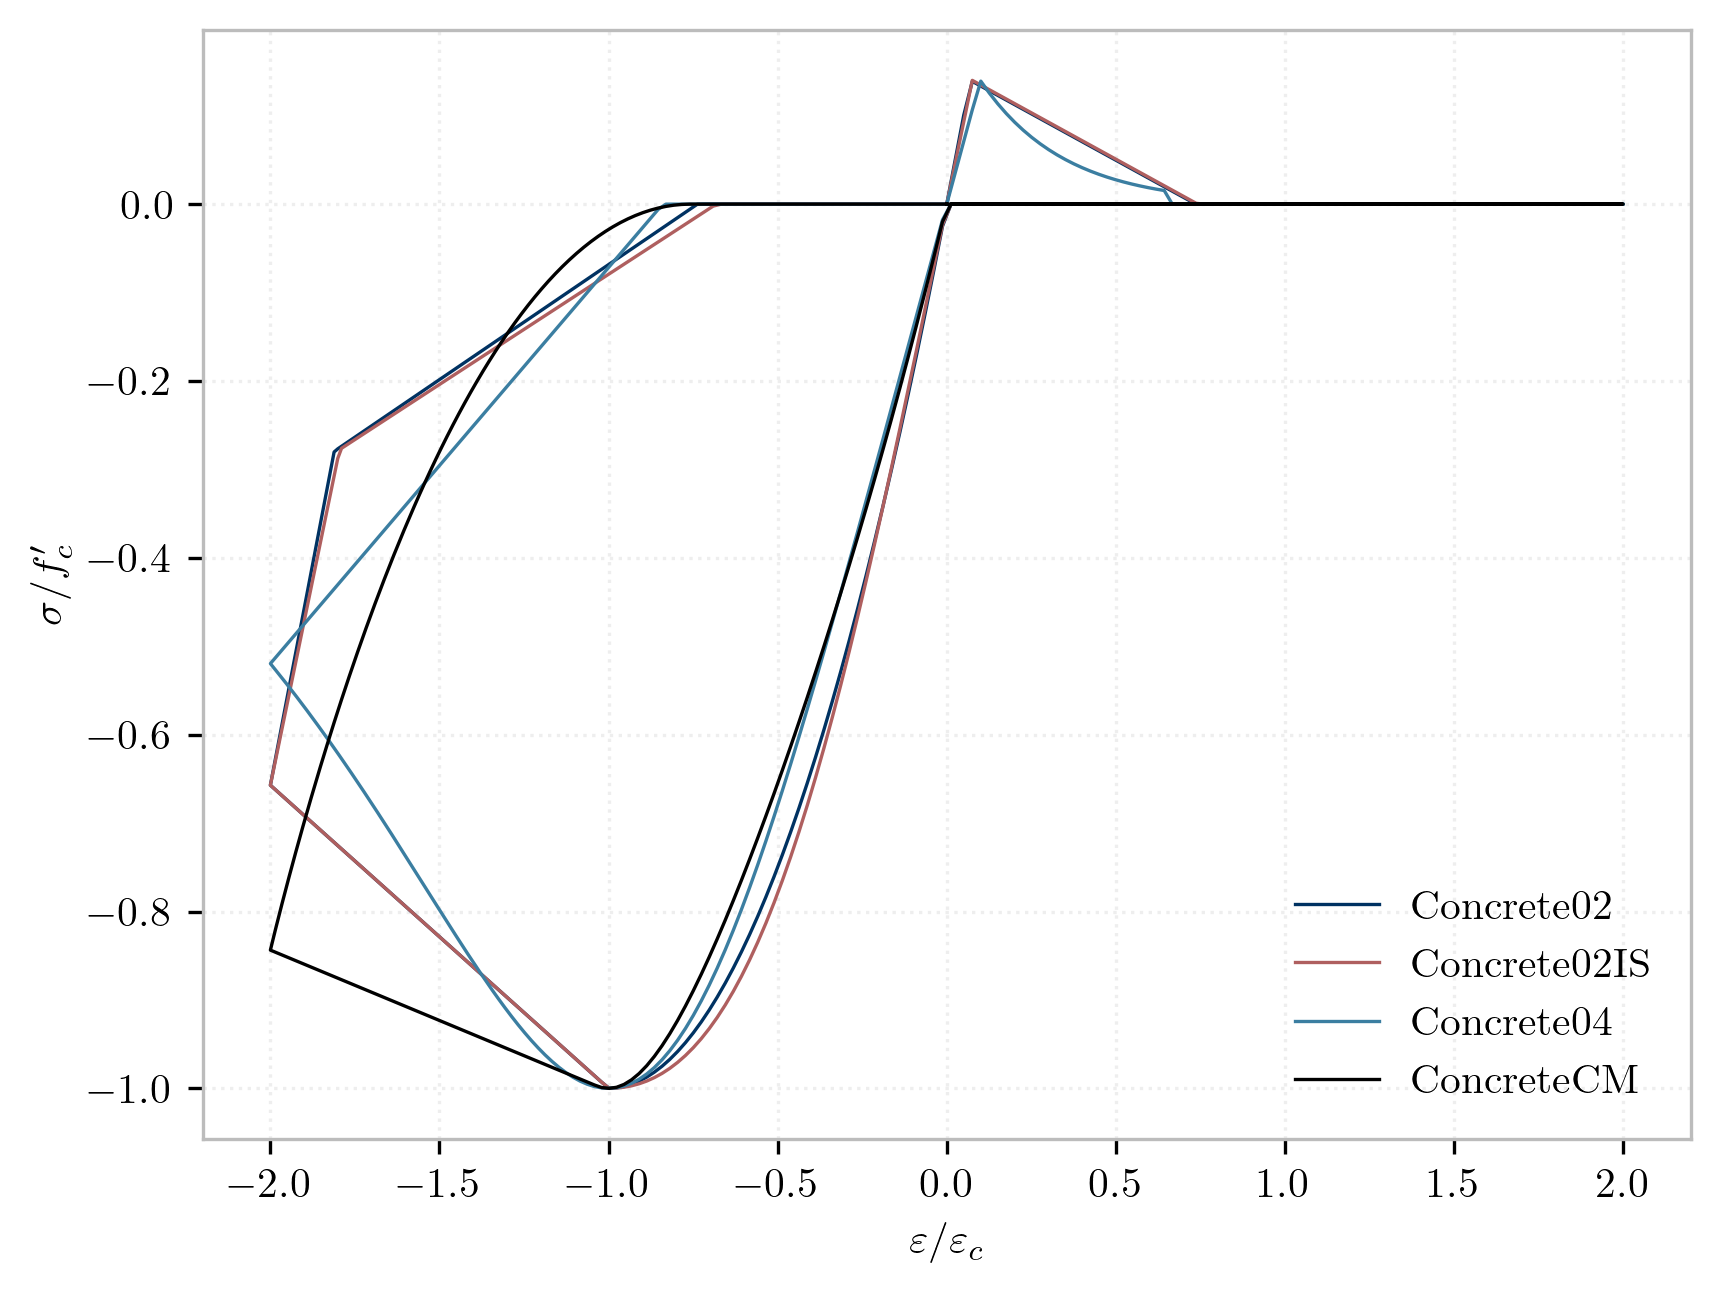

In [10]:
strain  = -2*eps1U*sin(linspace(0, 2*pi, 500))
fig, ax = plt.subplots()
ax.plot(strain/eps1U)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$\varepsilon/\varepsilon_c$")
ax.set_title("Strain history");

fig, ax = plt.subplots()

with uniaxial.Concrete02(fc1U, eps1U, fc2U, eps2U, _lambda, ftU, Ets).handle() as c:
    ax.plot(-strain/eps1U, [-c.getStress(e, commit=True)/fc for e in strain], label="Concrete02")
    
with uniaxial.Concrete02IS(Ec, fc1U, eps1U, fc2U, eps2U, [_lambda, ftU, Ets]).handle() as conc:
    ax.plot(-strain/eps1U, [-conc.getStress(e, commit=True)/fc for e in strain], label="Concrete02IS")

with uniaxial.Concrete04(fc1U, eps1U, eps2U, 4e3*ksi, [ftU, ftU/Ets]).handle() as conc:
    ax.plot(-strain/eps1U, [-conc.getStress(e, commit=True)/fc for e in strain], label="Concrete04")

with uniaxial.ConcreteCM(fc1U, eps1U, 4500*ksi, 7, 1.035, 0.30, 0.00008, 1.2, 10000).handle() as conc:
    ax.plot(-strain/eps1U, [-conc.getStress(e, commit=True)/fc for e in strain], label="ConcreteCM")

ax.legend()
ax.set_xlabel(r"$\varepsilon/\varepsilon_c$")
ax.set_ylabel(r"$\sigma/f'_c$");

In [11]:
strain = 0.02*sin(linspace(0, 5.5*pi, 300))*linspace(0.5, 1, 300)**2

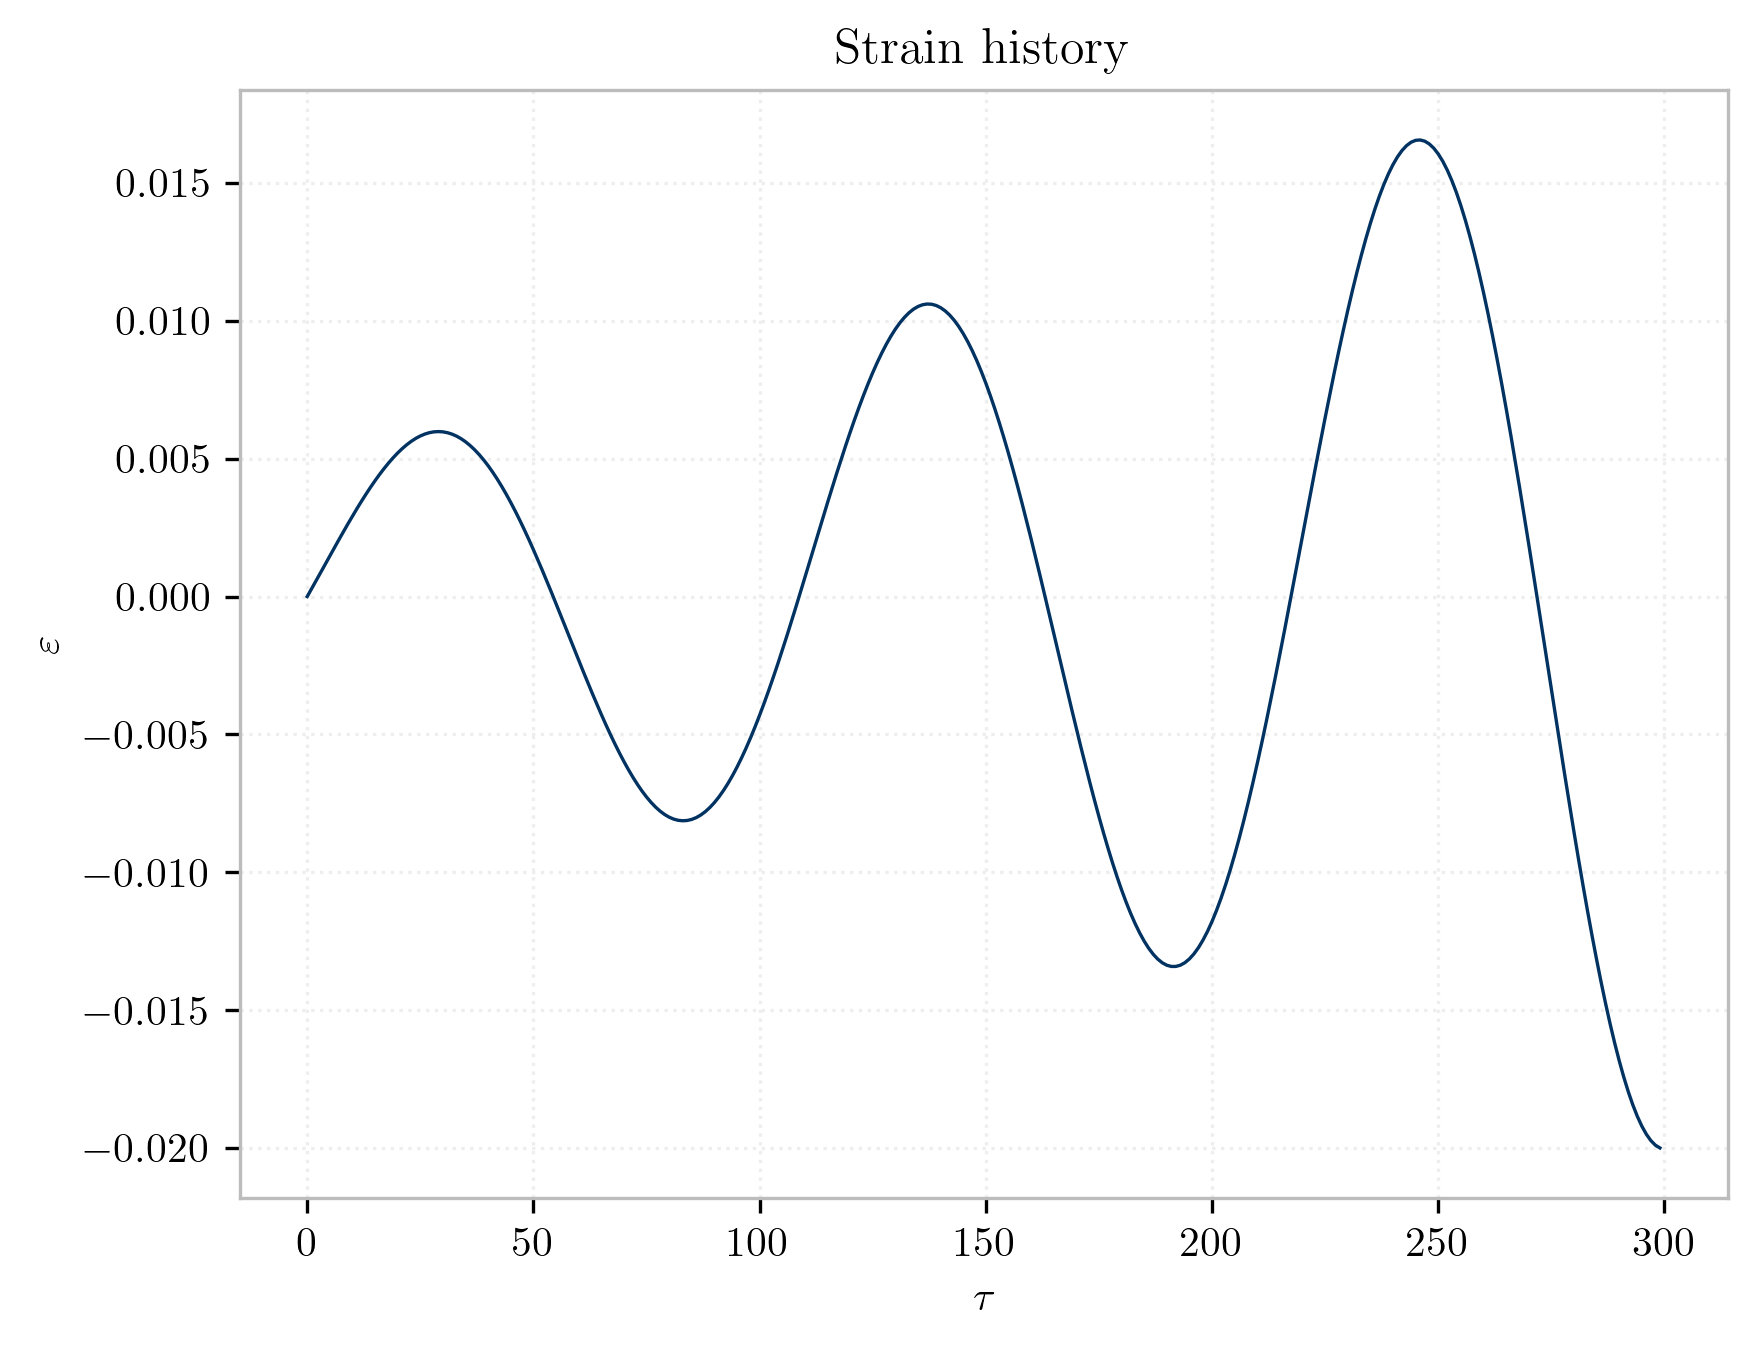

In [12]:
fig, ax = plt.subplots()
ax.plot(strain)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$\varepsilon$")
ax.set_title("Strain history");

## Composing Materials

Composing springs in structural analysis involves treating each spring as a simple force-displacement relationship, then combining them mathematically so the system reproduces the desired overall stiffness.

### Parallel Composition

Composing springs in parallel involves summing their stiffness values. The equivalent stiffness \( k_{\text{parallel}} \) is given by:

\[
k_{\text{parallel}} = k_1 + k_2
\]

<svg width="300" height="120" xmlns="http://www.w3.org/2000/svg">
  <!-- Parallel Spring 1 -->
  <path d="M50,30 L60,30 L70,50 L80,30 L90,50 L100,30 L110,50 L120,30" stroke="green" stroke-width="2" fill="none"/>
  
  <!-- Parallel Spring 2 -->
  <path d="M50,70 L60,70 L70,90 L80,70 L90,90 L100,70 L110,90 L120,70" stroke="green" stroke-width="2" fill="none"/>
  
  <!-- Connecting Lines -->
  <line x1="50" y1="30" x2="50" y2="70" stroke="black" stroke-width="1" stroke-dasharray="5,5"/>
  <line x1="120" y1="30" x2="120" y2="70" stroke="black" stroke-width="1" stroke-dasharray="5,5"/>
  
  <!-- Labels -->
  <text x="85" y="25" font-size="12" text-anchor="middle">Spring 1</text>
  <text x="85" y="105" font-size="12" text-anchor="middle">Spring 2</text>
  
  <!-- End Points -->
  <circle cx="50" cy="30" r="3" fill="black"/>
  <circle cx="50" cy="70" r="3" fill="black"/>
  <circle cx="120" cy="30" r="3" fill="black"/>
  <circle cx="120" cy="70" r="3" fill="black"/>
</svg>






Structural elements that might exhibit a flag-like response include certain types of bracing systems, energy dissipating devices, and connections in steel structures. These elements typically show a combination of elastic and plastic behavior with a distinct yield point, followed by a plateau and then strain hardening. This type of response is often seen in systems designed to absorb and dissipate energy during events like earthquakes, providing both stiffness and ductility.

This flag-like response can be simulated using two bilinear springs in parallel. By combining two springs with different stiffness and yield strengths, we can create a composite model that captures the initial stiffness, yielding, and post-yield behavior of the structural element. This approach allows for a more accurate representation of the complex behavior of materials and connections under cyclic loading conditions.

In [13]:
mat_a = uniaxial.Hardening(15e3, fy=15., H_iso=0., H_kin=5e1, name=1)
mat_b = uniaxial.ElasticBilin(45e3, 1e2, 15/15e3, name=2)

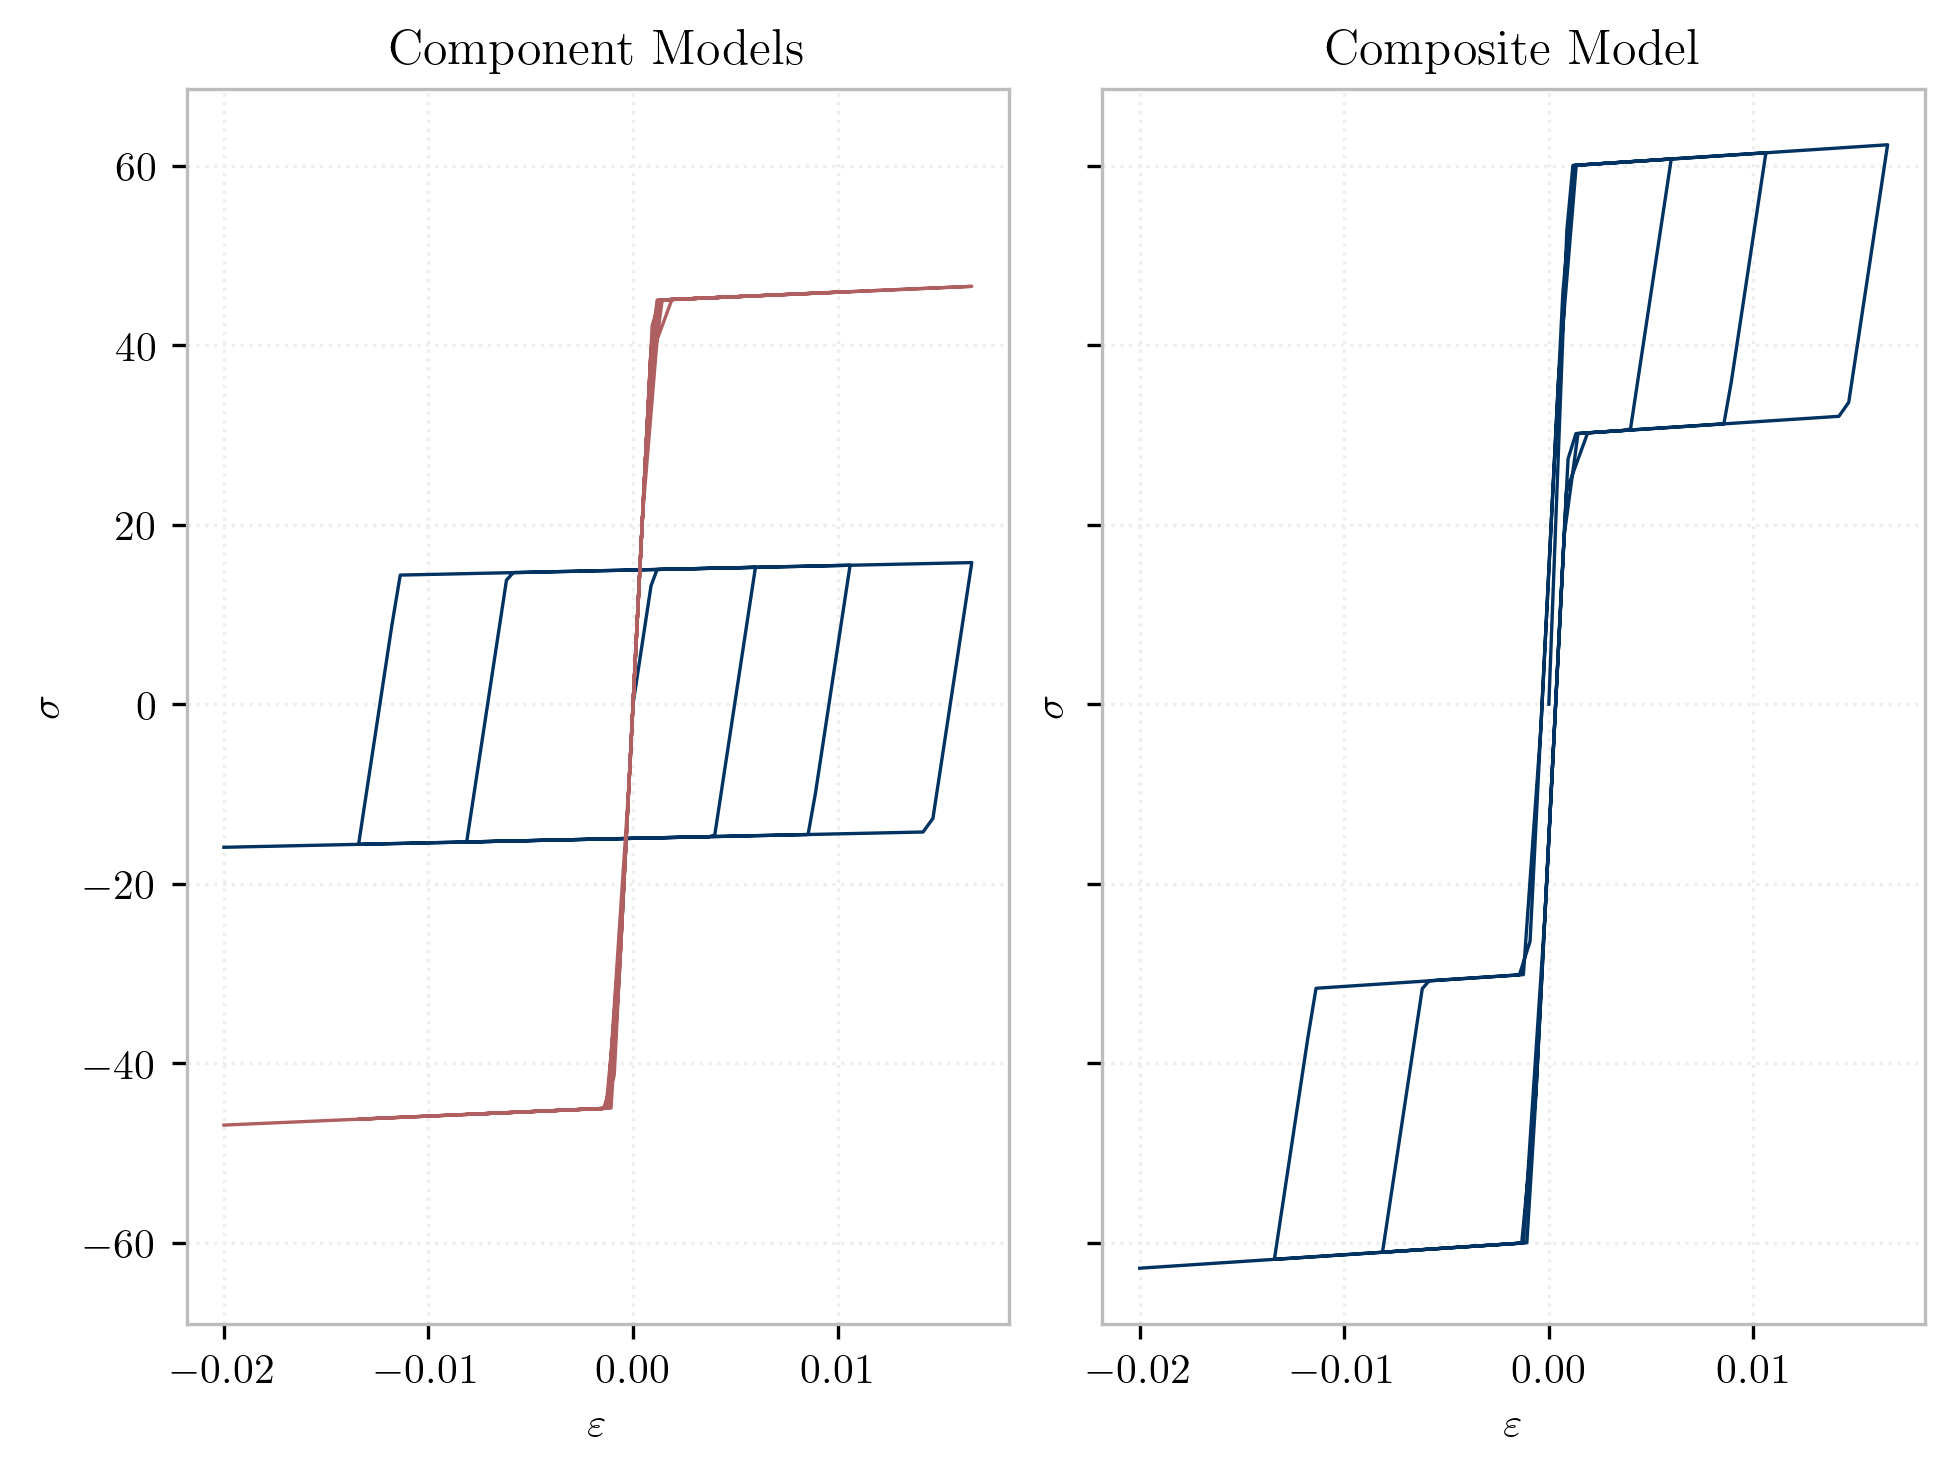

In [14]:
fig, ax = plt.subplots(1,2, sharey=True, constrained_layout=True)

with mat_a.handle() as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])

with mat_b.handle() as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])


# with mat_a as m:
#     ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])
with uniaxial.Parallel([mat_a, mat_b], name=3).handle() as m:
    ax[1].plot(strain, [m.getStress(e, commit=True) for e in strain])


ax[0].set_title("Component Models")
ax[1].set_title("Composite Model")
for a in ax:
    a.set_xlabel(r"$\varepsilon$");
    a.set_ylabel(r"$\sigma$");

### Series Composition

Composing springs in series involves summing their deflections. The equivalent stiffness \( k_{\text{series}} \) is given by:

$$
\frac{1}{k_{\text{series}}} = \frac{1}{k_1} + \frac{1}{k_2}
$$

<svg width="300" height="100" xmlns="http://www.w3.org/2000/svg">
  <!-- Series Spring 1 -->
  <path d="M20,50 L40,50 M40,50 L50,30 L60,50 L70,30 L80,50 L90,30 L100,50" stroke="blue" stroke-width="2" fill="none"/>
  
  <!-- Series Spring 2 -->
  <path d="M100,50 L120,50 M120,50 L130,30 L140,50 L150,30 L160,50 L170,30 L180,50" stroke="blue" stroke-width="2" fill="none"/>
  
  <!-- Connecting Lines -->
  <line x1="20" y1="50" x2="180" y2="50" stroke="black" stroke-width="1" stroke-dasharray="5,5"/>
  
  <!-- Labels -->
  <text x="50" y="25" font-size="12" text-anchor="middle">Spring 1</text>
  <text x="150" y="25" font-size="12" text-anchor="middle">Spring 2</text>
  
  <!-- End Points -->
  <circle cx="20" cy="50" r="3" fill="black"/>
  <circle cx="180" cy="50" r="3" fill="black"/>
</svg>

To combine two springs in series:

$$
k_{\text{series}} = \frac{1}{\left(\frac{1}{k_1} + \frac{1}{k_2}\right)}
$$


### Brittle Fracture

### Trilinear Response

In [15]:
mat_a = uniaxial.Hardening(40e3, fy=40., H_iso=0., H_kin=5e3, name=1)
mat_b = uniaxial.Hardening(30e3, fy=60., H_iso=0., H_kin=5e2, name=2)

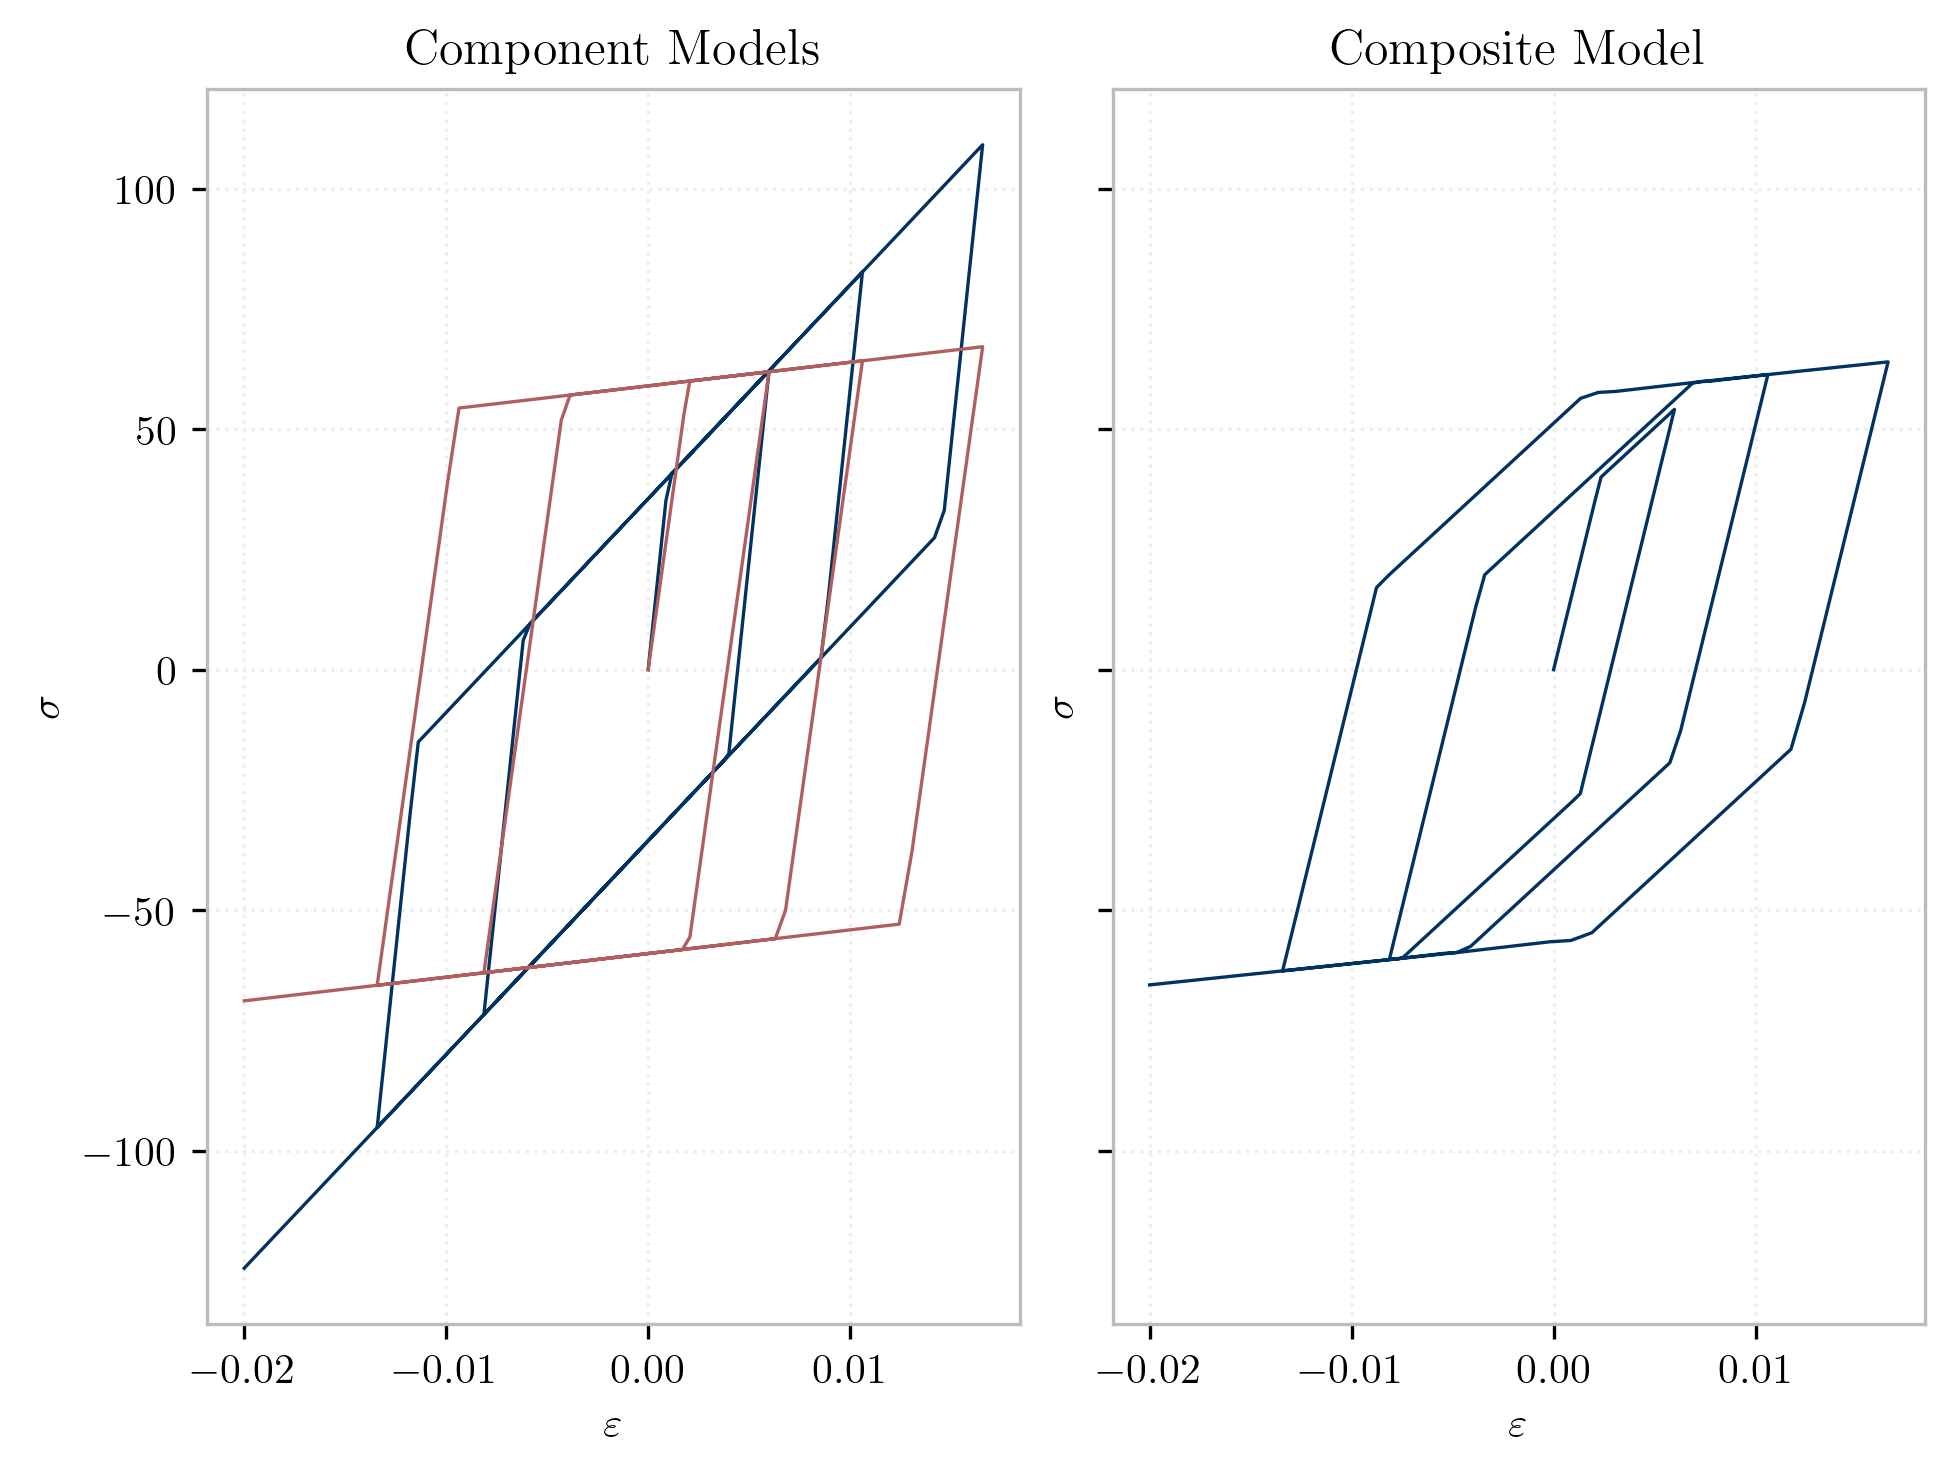

In [16]:
fig, ax = plt.subplots(1,2, sharey=True, constrained_layout=True)

with mat_a.handle() as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])
    
with mat_b.handle() as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])
    
with uniaxial.Series([mat_a, mat_b], name=3).handle() as m:
    ax[1].plot(strain, [m.getStress(e, commit=True) for e in strain])

    
ax[0].set_title("Component Models")
ax[1].set_title("Composite Model")
for a in ax:
    a.set_xlabel(r"$\varepsilon$");
    a.set_ylabel(r"$\sigma$");

### Slipping

In [17]:
mat_a = uniaxial.Hardening(30e3, fy=60., H_iso=0., H_kin=1e2, name=1)
mat_b = uniaxial.ElasticBilin(10.0, 30e3, 0.01, name=2)

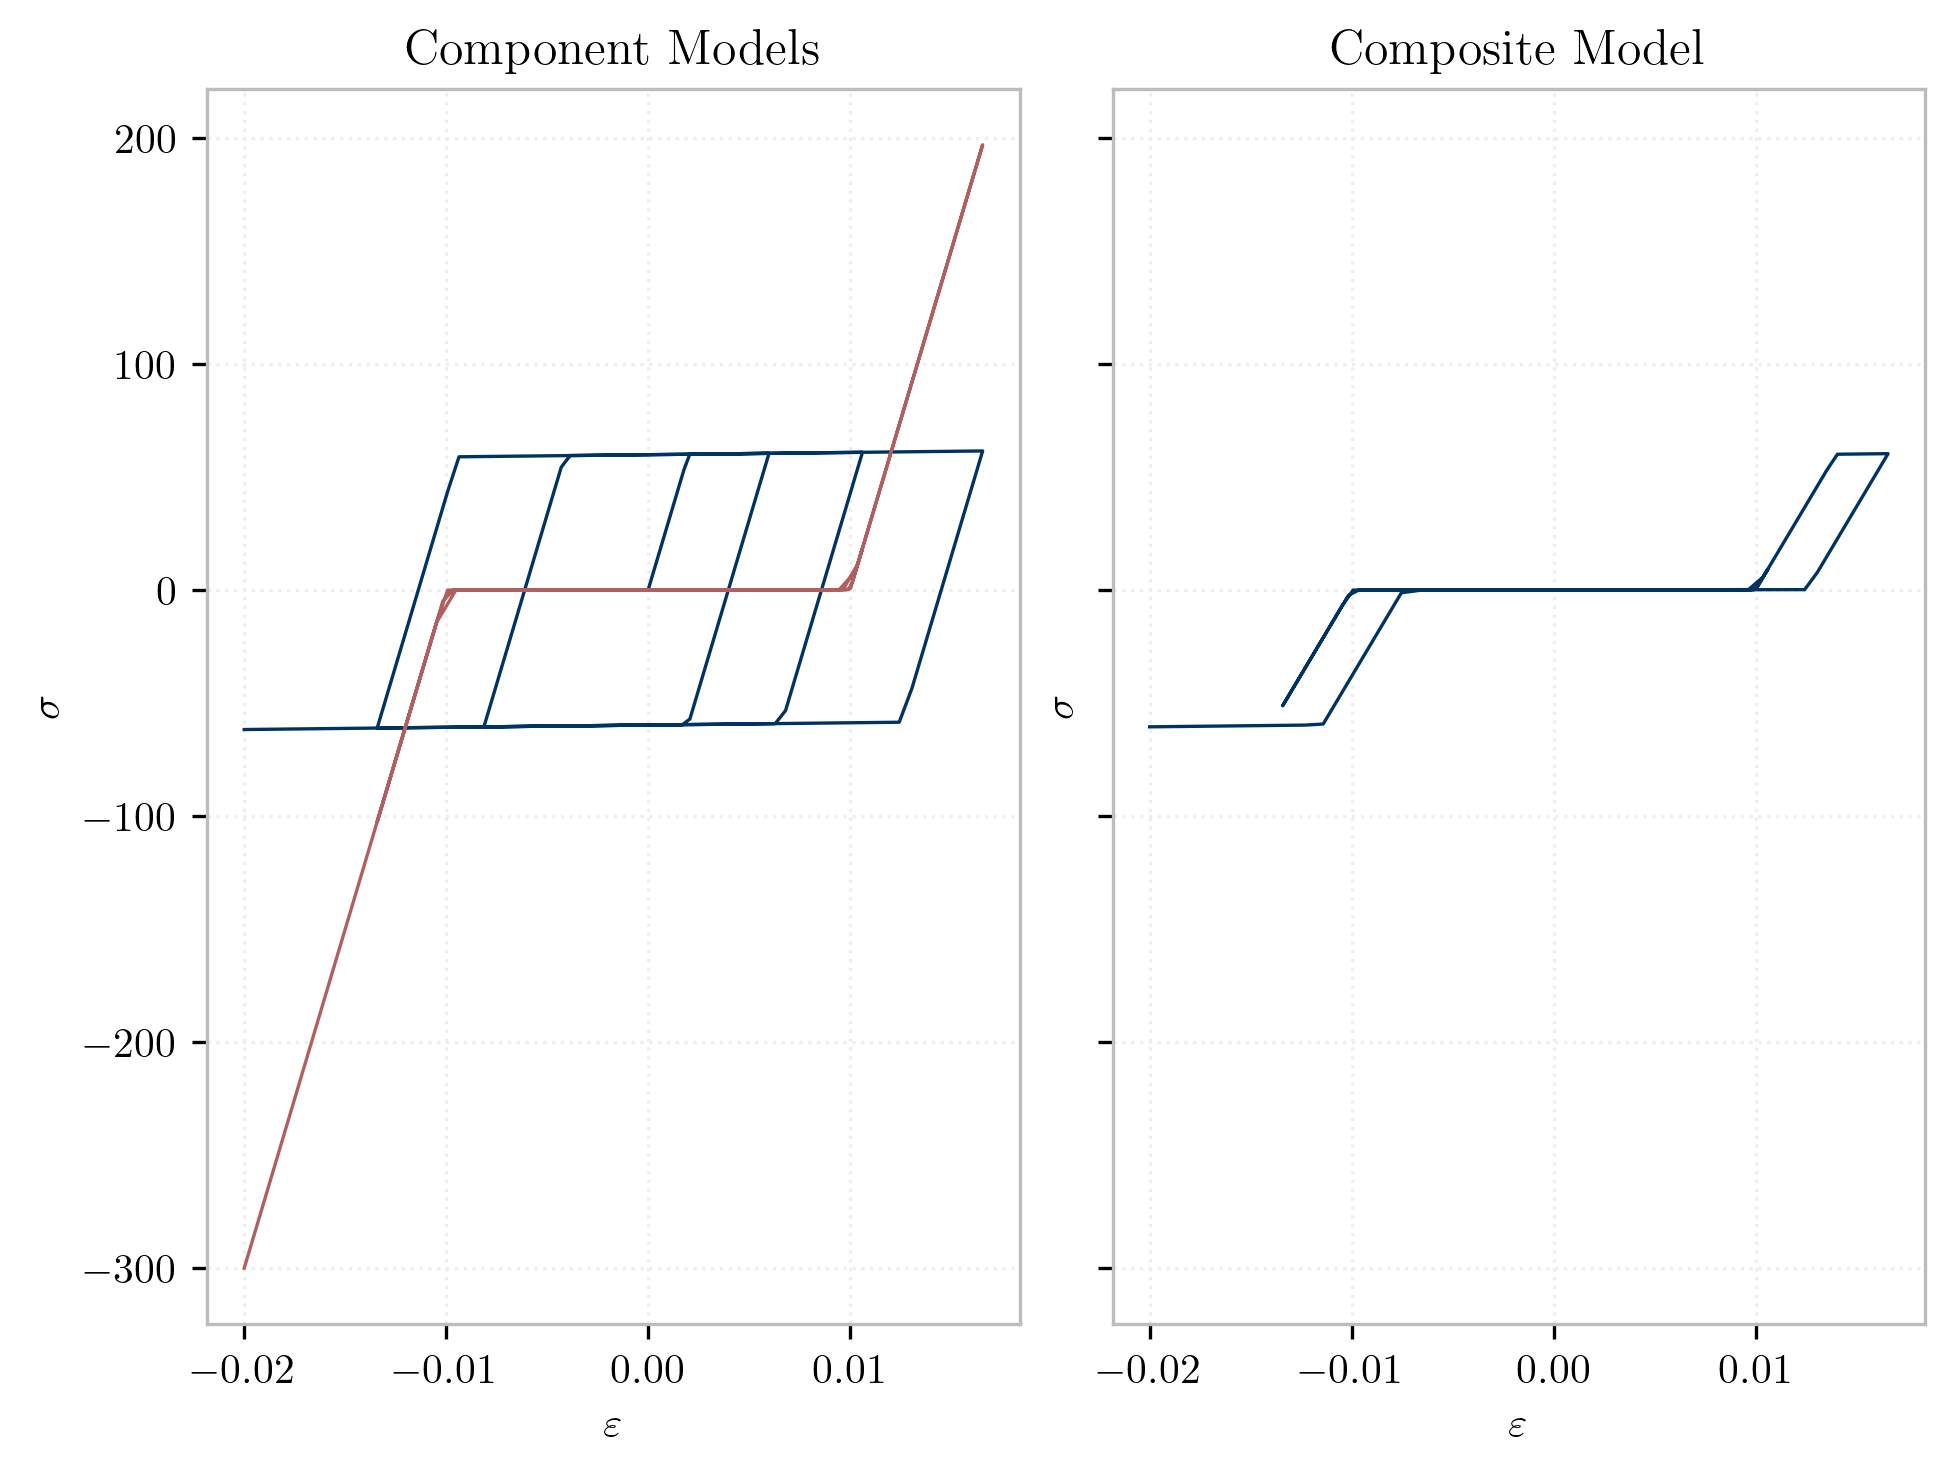

In [19]:
fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=True)

with mat_a.handle() as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])
    
with mat_b.handle() as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])

with uniaxial.Series([mat_a, mat_b], name=3).handle() as m:
    ax[1].plot(strain, [m.getStress(e, commit=True) for e in strain])


ax[0].set_title("Component Models")
ax[1].set_title("Composite Model")
for a in ax:
    a.set_xlabel(r"$\varepsilon$");
    a.set_ylabel(r"$\sigma$");